# II. Ensembles

В задачах нужно корректно реализовать функции, чтобы проходили тесты. 

## 1. Bootstrap.

### Алгоритм Bootstrap 
* Равномерно возьмем из выборки $N$ объектов **с возвращением**. То есть мы хотим сгенерировать псевдовыборку, в которой могут повторятся элементы из исходной выборки. 

* Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $M$ подвыборок $X_1, \dots, X_B$. 

* Посчитаем статистику T от каждой выборки $(T(X_1), \ldots, T(X_n))$

* Найдем итоговую статистику $T(X) = \frac{1}{B}\sum^{B}_{i}T(X_i)$

На вход массив чисел $X$ и число бутстрепных выборок $B$. Необходимо реализовать свой бутстреп и найти матожидание и стандартную ошибку у бутстрепных выборок.


### TASK

In [3]:
import numpy as np
from scipy.stats import sem # ищет SE среднего
import random

def get_stats(X, B):
    n = len(X)
    bootstrap = []
    for j in range(B):
        x_j = []
        for i in range(n):
            x_j.append(random.choice(X))
        bootstrap.append(x_j)
    bootstrap = np.array(bootstrap)
    mean = bootstrap.mean().mean()
    SE = sem(bootstrap, axis=1).mean()
    return mean, SE

### Open tests

In [4]:
######################################################
X = np.array([37,43,38,36,17,40,40,45,41,84])
B = 100000

mean, se = get_stats(X, B)

assert np.abs(mean - 42.1) < 0.05
assert np.abs(se - 4.56) < 0.03
######################################################

# 2. Bagging

Необходимо реализовать свой небольшой беггинг на деревьях заданной грубины

* бустингом сделать несколько выборок $X_1, \ldots, X_B$
* обучить на этих выборках алгоритмы: $a_1(\cdot), \ldots, a_B(\cdot)$

Получить результат беггинга как:
$$a(x) = \frac{1}{B}\sum_{b=1}^{B}a_b(x)$$


# TASK

In [5]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR

def bagging(X_train, y_train, X_test, boot_count, depth):
    estimators = np.array([DTR(max_depth=depth) for _ in range(boot_count)])
    a = []
    for i in range(boot_count):
        X_i = []
        y_i = []
        n = len(X_train)
        for j in range(n):
            indx = random.choice(np.arange(n))
            X_i.append(X_train[indx])
            y_i.append(y_train[indx])
        estimators[i].fit(X_i, y_i)
        a.append(estimators[i].predict(X_test))
        
    a = np.array(a)    
    y_pred = a.mean(axis=0)
    
    return y_pred

In [6]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_equal, assert_almost_equal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

######################################################

X_train = np.array([[0, 0], [1, 1], [5, 5], [8, 8], [10, 10]])
y_train = np.array([0, 1, 5, 8, 10])
X_test  = np.array([[4, 4], [6, 6]])
y_test  = np.array([4, 6])

B = 1000

y_pred = bagging(X_train, y_train, X_test, boot_count=B, depth=3)

assert_array_almost_equal(y_pred, np.array([4, 6]), decimal=0)

######################################################

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)


y_pred = bagging(X_train, y_train, X_test, boot_count=200, depth=10)

y_dt_pred = DecisionTreeRegressor().fit(X_train, y_train).predict(X_test)
y = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

print(mean_squared_error(y, y_test))
print(mean_squared_error(y_dt_pred, y_test))
print(mean_squared_error(y_pred, y_test))
assert mean_squared_error(y_pred, y_test) < 15

14.644658046052632
19.569407894736845
13.888794071158092


## 3. X-regression

Необходимо найти наилучшие параметры для XGBRegression, обучить модель и вернуть ее. Данные берутся из папки data.

Сам гридсерч или нативное исследование необходимо делать вне функции обработки, чтобы не получить TL.

### TASK

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [32]:
xgb = XGBRegressor()
parameters = {'nthread': [4],
              'objective': ['reg:linear'],
              'learning_rate': [0.01, 0.03, 0.05],
              'max_depth': [3, 4, 5, 6, 7, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [1],
              'colsample_bytree': [0.7, 0.8],
              'n_estimators': [500]}
xgb_grid = GridSearchCV(xgb, parameters, cv=2, n_jobs=2,
                        verbose=True)
xgb_grid.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             early_stopping_rounds=100,
             verbose=True)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.2s


[17:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[17:27:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.04251	validation_1-rmse:1.50203
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.00978	validation_1-rmse:1.47678


[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:   29.9s finished


[2]	validation_0-rmse:2.97794	validation_1-rmse:1.45182
[3]	validation_0-rmse:2.94770	validation_1-rmse:1.43253
[4]	validation_0-rmse:2.91888	validation_1-rmse:1.40990
[5]	validation_0-rmse:2.88982	validation_1-rmse:1.39007
[6]	validation_0-rmse:2.86197	validation_1-rmse:1.37102
[7]	validation_0-rmse:2.83572	validation_1-rmse:1.35301
[8]	validation_0-rmse:2.81040	validation_1-rmse:1.33622
[9]	validation_0-rmse:2.78587	validation_1-rmse:1.32183
[10]	validation_0-rmse:2.76221	validation_1-rmse:1.30478
[11]	validation_0-rmse:2.73858	validation_1-rmse:1.29140
[12]	validation_0-rmse:2.71607	validation_1-rmse:1.27949
[13]	validation_0-rmse:2.69440	validation_1-rmse:1.26477
[14]	validation_0-rmse:2.67324	validation_1-rmse:1.25541
[15]	validation_0-rmse:2.65262	validation_1-rmse:1.24203
[16]	validation_0-rmse:2.63297	validation_1-rmse:1.23567
[17]	validation_0-rmse:2.61362	validation_1-rmse:1.22893
[18]	validation_0-rmse:2.59490	validation_1-rmse:1.21781
[19]	validation_0-rmse:2.57631	validati

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [28]:
def xreg(X_train: np.array, y_train:np.array) -> XGBRegressor:
    model = xgb_grid.best_estimator_
    return model

### OPEN TESTS

In [30]:
import pandas as pd
import time
from sklearn.metrics import mean_squared_error as MSE

df = pd.read_csv('data/Financial Distress.csv')

X = df.drop('Financial Distress', axis=1)
y = df['Financial Distress']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

t1 = time.time()
xgb_model = xreg(X_train, y_train)
t2 = time.time()

assert t2 - t1 < 10

y_pred = xgb_model.predict(X_test)

assert type(xgb_model) == xgboost.sklearn.XGBRegressor
assert MSE(y_pred, y_test) < 3
print('Well Done')

Well Done


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.6s


[17:23:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.04251	validation_1-rmse:1.50203
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.00978	validation_1-rmse:1.47678
[2]	validation_0-rmse:2.97794	validation_1-rmse:1.45182
[3]	validation_0-rmse:2.94770	validation_1-rmse:1.43253
[4]	validation_0-rmse:2.91888	validation_1-rmse:1.40990

[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:   27.8s finished


[5]	validation_0-rmse:2.88982	validation_1-rmse:1.39007
[6]	validation_0-rmse:2.86197	validation_1-rmse:1.37102
[7]	validation_0-rmse:2.83572	validation_1-rmse:1.35301
[8]	validation_0-rmse:2.81040	validation_1-rmse:1.33622
[9]	validation_0-rmse:2.78587	validation_1-rmse:1.32183
[10]	validation_0-rmse:2.76221	validation_1-rmse:1.30478
[11]	validation_0-rmse:2.73858	validation_1-rmse:1.29140
[12]	validation_0-rmse:2.71607	validation_1-rmse:1.27949
[13]	validation_0-rmse:2.69440	validation_1-rmse:1.26477
[14]	validation_0-rmse:2.67324	validation_1-rmse:1.25541
[15]	validation_0-rmse:2.65262	validation_1-rmse:1.24203
[16]	validation_0-rmse:2.63297	validation_1-rmse:1.23567
[17]	validation_0-rmse:2.61362	validation_1-rmse:1.22893
[18]	validation_0-rmse:2.59490	validation_1-rmse:1.21781
[19]	validation_0-rmse:2.57631	validation_1-rmse:1.21226
[20]	validation_0-rmse:2.55872	validation_1-rmse:1.20171
[21]	validation_0-rmse:2.54158	validation_1-rmse:1.19862
[22]	validation_0-rmse:2.52448	valid

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [27]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 4. CatFeatures

Обучите модель классификации катбуста на предложенных данных и верните обученную модель. 

Воспользуйтесь встроенной обработкой категориальных признаков. Не забудьте обработать Nan значения.

### TASK

In [70]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
def catfeatures(df: pd.DataFrame):
    x_train = df.drop('dep_delayed_15min',axis=1)
    y_train = df['dep_delayed_15min'].replace({'N' : 0, 'Y' : 1})
    clf = CatBoostClassifier(iterations=100,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)
    clf.fit(x_train,y_train, cat_features=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'])
    return clf

In [71]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


### TESTS

In [72]:
df = pd.read_csv('data/flight_delays_train.csv')
df_train = df[:7000]

t1 = time.time()
model = catfeatures(df_train)
t2 = time.time()

assert t2 - t1 < 10
assert type(model) == catboost.CatBoostClassifier

df_test = pd.read_csv('data/flight_catfeature_test.csv')
df_test = df_test.drop('Unnamed: 0', axis=1)
X_test = df_test.drop('dep_delayed_15min',axis=1)
y_test = df_test['dep_delayed_15min']

y_pred = model.predict(X_test)
assert accuracy_score(y_test, y_pred) > 0.80 
print('Well Done')

Well Done


In [73]:
accuracy_score(y_test, y_pred)

0.8124

## 5. Производные для регрессии

Пусть мы хотим бустить регрессию со стандартной функцией потерь $MSE$:

$$\mathcal{L}(a, x,y) = (a(x_i) - y_i)^2$$

Необходимо найти через взятие производных:

1. Константный вектор $[f_0]_{i=1}^{N}$
$$f_0(x) = \arg\min_{ c\in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

2. Градиенты функции потерь
$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

3. Коэффициенты при композиции 
$$\alpha_{t + 1} = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t}(x_i) + \alpha b_{t+1}(x_i), y_i)$$

### TASK

In [7]:
def init(y_i: np.array) -> float:
    f_0 = y_i.mean()
    return f_0

def grad(a: np.array, y: np.array) -> np.array:
    g = -2*(a-y)
    return g

def alpha(f :np.array, b: np.array, y: np.array) -> float:
    alpha = np.dot(f-y,b)/(np.dot(b,b))
    return alpha

### TESTS

In [37]:
y = np.array([1, 2, 3])
f = np.array([2, 2, 2])
b = np.array([0, 2, 4])

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 2.0)   < 1e-9
assert_array_almost_equal(g, np.array([-2, 0, 2]))
assert np.abs(al - (-0.2)) < 1e-9
######################################################
y = np.arange(20)
f = np.ones(20) * 10
b = np.arange(20) - 1

f_0 = init(y)
g = grad(f,y)
al = alpha(f,b,y)


assert np.abs(f_0 - 9.5)   < 1e-2
assert_array_almost_equal(g, np.arange(-20,20, 2))
assert np.abs(al - (-0.2748)) < 1e-2
print('Well Done!')

Well Done!


## 6. GradientBoosting

Реализуйте градиентный бустинг на решающих деревьях для регрессии с логгированием.Верните модель, которая будет хранить в себе `n_estimatos` обученных деревьев и коэффициенты, чтобы с их помощью потом найти результат предсказания.

Также необходимо реализовать логгирование в течение обучения.
* `self.estimators` - лист c деревьями
* `self.alpha` - лист с коэффициентами альфа
* `self.f_list` - лист со значениями комбинаций алгоритма $f_T(x_i) = f_0(x_i) + \sum_{t=1}^{T}\alpha_tb_t(x_i)$
* `self.g_list` - лист с векторами градиентов на каждой итерации $g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$
* `self.b_list` - лист со значениями базового обучаемого дерева на тренировачной выборке на каждой итерации 

Примечания:
* Обрывать алгоритм не нужно, необходимо обучить все деревья.
* Начальный константный вектор из $f_0$ логгировать не нужно, однако не забудьте его добавить в `predict` c нужным количеством объектов!

### TASK

In [51]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error

class MyGradBoost():
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.estimators_ = np.array([DTR(max_depth=self.max_depth) for _ in range(n_estimators)])
        self.alpha = []
        self.f_list = []
        self.b_list = []
        self.g_list = []
        
    def fit(self, X_train: np.array, y_train: np.array): 
        f_0 = np.array([init(y_train) for i in range(len(y_train))])
        f_current = f_0
        for t in range(self.n_estimators):
            g_t = grad(f_current, y_train)
            self.estimators_[t].fit(X_train, g_t)
            b_t = self.estimators_[t].predict(X_train)
            a_t = alpha(f_current, b_t, y_train)
            f_current = f_current + a_t*b_t
            self.f_list.append(f_current)
            self.alpha.append(a_t)
            self.b_list.append(b_t)
            self.g_list.append(g_t)
        return self
        
    def predict(self, X_test) -> np.array:
        y_pred = np.array([init(y_train) for i in range(len(X_test))])
        for t in range(self.n_estimators):
            y_pred = y_pred + (self.alpha[t] * self.estimators_[t].predict(X_test))
        return y_pred
    
    def score(self, X_test, y_test)-> np.array:
        return mean_squared_error(self.predict(X_test), y_test)

### TESTS

In [57]:
n_estimators = 2
max_depth=3
X_train = np.array([[0], [1], [2], [3], [4]])
y_train = np.array([0, 2, 4, 2, 0])
X_test  = np.array([[1.2], [2.3]])
y_test  = np.array([2.2, 3.7])

model = MyGradBoost(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
#assert model.score(X_test, y_test) < 0.2
######################################################
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)


model = MyGradBoost().fit(X_train, y_train)

#assert model.score(X_test, y_test) < 0.025


model = MyGradBoost(n_estimators=100, 
                    max_depth=1).fit(X_train, y_train)

assert model.score(X_test, y_test) < 0.017
print('Well Done')

AssertionError: 

# Самопроверка

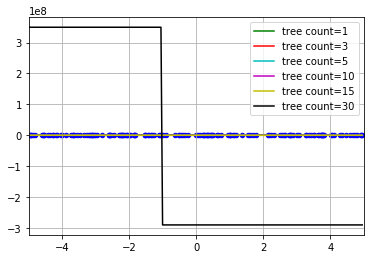

In [60]:
import matplotlib.pyplot as plt
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()



model = MyGradBoost(n_estimators=30, 
                    max_depth=1).fit(X_train, y_train)

ind =  [1,3,5,10,15,30]

# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1,3,5,10,15,30]
f = np.array(model.f_list)
for i, n in enumerate(n_est):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.plot(X_train, f[n-1], color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()